✅ Data generated: 214437 hits.
📂 Saved to: C:/Users/tanma/FYP\synthetic_event_hits.csv

Event Summary:
label
0    2910
1      90
Name: count, dtype: int64


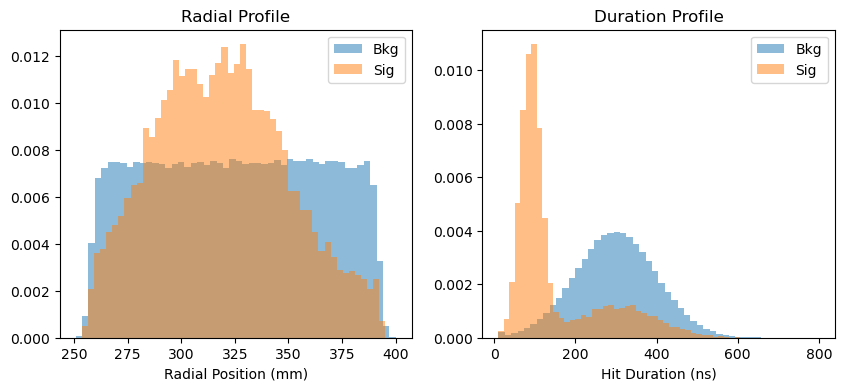

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# --- PATH CONFIGURATION (MODIFIED) ---
# We define your new clean directory here
BASE_DIR = "C:/Users/tanma/FYP"
os.makedirs(BASE_DIR, exist_ok=True) # Ensure the folder exists

# The output file will be saved directly inside FYP
OUT_CSV = os.path.join(BASE_DIR, "synthetic_event_hits.csv")
SEED = 42
rng = np.random.default_rng(SEED)

def generate_synthetic_events(
    n_events=3000,
    avg_hits_bkg=70,
    avg_hits_sig=120,
    signal_event_frac=0.03,
    rng_seed=SEED
):
    """
    Generates synthetic CDC hits.
    Note: 'reco_momentum' is generated here as a TRUTH label for analysis,
    but we will EXCLUDE it from training in the next step to avoid data leakage.
    """
    rng = np.random.default_rng(rng_seed)
    hits_list = []

    n_signal_events = int(n_events * signal_event_frac)
    n_bkg_events = n_events - n_signal_events

    # Create event table
    event_ids = np.arange(n_events)
    is_signal_arr = np.array([0]*n_bkg_events + [1]*n_signal_events)
    rng.shuffle(is_signal_arr)

    # Approximate layer geometry (mm)
    layer_radii = np.linspace(260.0, 390.0, 30)

    for eid, is_sig in zip(event_ids, is_signal_arr):
        # Hit counts
        mean_hits = avg_hits_sig if is_sig else avg_hits_bkg
        n_hits = max(4, int(rng.poisson(lam=mean_hits)))

        # Signal physics: localized clusters, coherent time, specific momentum
        if is_sig:
            cth_multiplicity = int(np.clip(rng.poisson(3), 0, 8))
            reco_momentum = float(rng.normal(loc=105.0, scale=3.0)) # Signal peak ~105 MeV
            cluster_phi = rng.uniform(0, 2*np.pi)
            cluster_layer_center = rng.integers(low=6, high=24)
        else:
            cth_multiplicity = int(np.clip(rng.poisson(1), 0, 8))
            reco_momentum = float(rng.normal(loc=90.0, scale=15.0)) # Background smear
            cluster_phi = None
            cluster_layer_center = None

        # CTH Time
        if cth_multiplicity >= 2:
            cth_time = float(rng.normal(loc=0.0, scale=5.0))
        else:
            cth_time = float(rng.normal(loc=0.0, scale=50.0))

        # Generate hits
        for h in range(n_hits):
            # Layer Selection
            if is_sig and rng.random() < 0.7:
                # Signal tends to cluster around a track
                layer_id = int(np.clip(int(rng.normal(loc=cluster_layer_center, scale=3)), 1, 30))
            else:
                layer_id = int(rng.integers(1, 31))

            # Geometry
            wire_id = int(rng.integers(0, 200))
            radial_position = float(layer_radii[layer_id-1] + rng.normal(0, 2.5))

            # Time (Signal = coherent, Background = uniform)
            if is_sig and cluster_phi is not None and rng.random() < 0.6:
                hit_time = float(rng.normal(loc=200.0 + rng.normal(0,5), scale=6.0))
            else:
                hit_time = float(rng.uniform(0, 1100.0))

            # Duration (Signal = shorter drift)
            if is_sig and rng.random() < 0.7:
                hit_duration = float(rng.normal(90.0, 25.0))
            else:
                hit_duration = float(rng.normal(300.0, 100.0))
            hit_duration = float(np.clip(hit_duration, 10.0, 1200.0))

            # Energy (2-bit ADC)
            if is_sig and rng.random() < 0.7:
                center_val = rng.choice([1,2,3], p=[0.3, 0.5, 0.2])
                left_val = int(np.clip(center_val + rng.choice([-1,0,1]), 0, 3))
                right_val = int(np.clip(center_val + rng.choice([-1,0,1]), 0, 3))
            else:
                if rng.random() < 0.7: # Low energy bkg
                    left_val, center_val, right_val = rng.integers(0,4,3)
                elif rng.random() < 0.9: # Proton spike
                    center_val = int(rng.choice([3,2], p=[0.8,0.2]))
                    left_val, right_val = rng.integers(0,2,2)
                else:
                    left_val, center_val, right_val = rng.integers(0,4,3)

            hits_list.append({
                "event_id": int(eid),
                "is_signal_event": int(is_sig),
                "layer_id": int(layer_id),
                "wire_id": int(wire_id),
                "radial_position": float(radial_position),
                "E_left": left_val, "E_center": center_val, "E_right": right_val,
                "hit_time": float(hit_time),
                "hit_duration": float(hit_duration),
                "cth_multiplicity": int(cth_multiplicity),
                "cth_time": float(cth_time),
                "reco_momentum": float(reco_momentum), 
                "label": int(is_sig)
            })

    return pd.DataFrame(hits_list)

# Execution
df = generate_synthetic_events()
df.to_csv(OUT_CSV, index=False)
print(f"✅ Data generated: {len(df)} hits.")
print(f"📂 Saved to: {OUT_CSV}")

# --- Visualizations ---
print("\nEvent Summary:")
print(df.groupby("event_id")["label"].first().value_counts())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df[df.label==0].radial_position, bins=50, alpha=0.5, label='Bkg', density=True)
plt.hist(df[df.label==1].radial_position, bins=50, alpha=0.5, label='Sig', density=True)
plt.xlabel("Radial Position (mm)")
plt.legend()
plt.title("Radial Profile")

plt.subplot(1, 2, 2)
plt.hist(df[df.label==0].hit_duration, bins=50, alpha=0.5, label='Bkg', density=True)
plt.hist(df[df.label==1].hit_duration, bins=50, alpha=0.5, label='Sig', density=True)
plt.xlabel("Hit Duration (ns)")
plt.legend()
plt.title("Duration Profile")
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
import os

# --- PATH CONFIGURATION ---
# (Ensuring we use the same base directory defined in the previous cell)
BASE_DIR = "C:/Users/tanma/FYP"

print("\n[2/5] Feature Engineering & Splitting...")

# 1. Generate Derived Features (Hardware Friendly)
df["E_sum"] = df["E_left"] + df["E_center"] + df["E_right"]
df["E_max"] = df[["E_left", "E_center", "E_right"]].max(axis=1)
df["E_asym"] = df["E_left"] - df["E_right"]

# 2. Corrected Time Feature (Hardware Logic Fix)
df["t_rel"] = df["hit_time"] / 1100.0

# 3. Define Input Features (Physics Logic Fix)
features_for_training = [
    "radial_position", "E_left", "E_center", "E_right", 
    "E_sum", "E_max", "E_asym", 
    "hit_time", "t_rel", "hit_duration"
]

# 4. Prepare X and y
X = df[features_for_training]
y = df["label"]

# 5. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- ADDED: SAVE SPLIT DATA TO FYP FOLDER ---
print("\n💾 Saving Split Data to FYP Folder...")
X_train.to_csv(os.path.join(BASE_DIR, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(BASE_DIR, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(BASE_DIR, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(BASE_DIR, "y_test.csv"), index=False)

print(f"✅ Features generated. Training shape: {X_train.shape}")
print(f"   Signal samples in Train: {sum(y_train==1)}")
print(f"   Background samples in Train: {sum(y_train==0)}")
print(f"📂 Data saved to {BASE_DIR}")
print("\nFirst 5 Training Rows:")
print(X_train.head())


[2/5] Feature Engineering & Splitting...

💾 Saving Split Data to FYP Folder...
✅ Features generated. Training shape: (171549, 10)
   Signal samples in Train: 8753
   Background samples in Train: 162796
📂 Data saved to C:/Users/tanma/FYP

First 5 Training Rows:
        radial_position  E_left  E_center  E_right  E_sum  E_max  E_asym  \
206459       352.071930       3         3        2      8      3       1   
108761       297.884757       3         2        2      7      3       1   
34071        376.203400       1         3        1      5      3       0   
98530        294.477335       1         2        3      6      3      -2   
11137        388.254544       0         1        0      1      1       0   

           hit_time     t_rel  hit_duration  
206459   603.770402  0.548882    515.597630  
108761  1086.220333  0.987473    313.321204  
34071    644.669096  0.586063    226.247155  
98530    555.721009  0.505201    266.009131  
11137   1001.494743  0.910450    531.000103  


In [3]:
import os
import urllib.request
import zipfile

# --- PATH CONFIGURATION ---
BASE_DIR = "C:/Users/tanma/FYP"
os.makedirs(BASE_DIR, exist_ok=True) # Safety check

print("⚡ Git not found. Downloading Xilinx HLS Headers via Python...")

# 1. Download the repository as a ZIP file
url = "https://github.com/Xilinx/HLS_arbitrary_Precision_Types/archive/refs/heads/master.zip"
# MODIFIED: Save zip to FYP folder
zip_filename = os.path.join(BASE_DIR, "hls_headers.zip")
# MODIFIED: Extract to FYP folder
extract_dir = os.path.join(BASE_DIR, "xilinx_headers")

try:
    urllib.request.urlretrieve(url, zip_filename)
    print(f"   Download complete: {zip_filename}")

    # 2. Extract the ZIP
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"   Extraction complete to: {extract_dir}")

    # 3. Set the Environment Variable
    # The zip usually extracts into a folder named "HLS_arbitrary_Precision_Types-master"
    inner_folder = "HLS_arbitrary_Precision_Types-master"
    include_path = os.path.abspath(os.path.join(extract_dir, inner_folder, "include"))
    
    # Check if the path actually exists to be safe
    if os.path.exists(include_path):
        # NOTE: This sets the variable for THIS Jupyter session only.
        os.environ["XILINX_AP_INCLUDE"] = include_path
        print(f"✅ Fixed! XILINX_AP_INCLUDE set to: {include_path}")
    else:
        print(f"❌ Error: Could not find 'include' folder at {include_path}")

except Exception as e:
    print(f"❌ Download Failed: {e}")

⚡ Git not found. Downloading Xilinx HLS Headers via Python...
   Download complete: C:/Users/tanma/FYP\hls_headers.zip
   Extraction complete to: C:/Users/tanma/FYP\xilinx_headers
✅ Fixed! XILINX_AP_INCLUDE set to: C:\Users\tanma\FYP\xilinx_headers\HLS_arbitrary_Precision_Types-master\include


In [15]:
import xgboost as xgb
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# --- PATH CONFIGURATION ---
BASE_DIR = "C:/Users/tanma/FYP"
# Artifacts go here (JSONs, H5s)
FPGA_DIR = os.path.join(BASE_DIR, "fpga_artifacts")
os.makedirs(FPGA_DIR, exist_ok=True)

print("\n[3/5] GBDT Training (Software Only)...")

# 1. Hardware-Friendly Parameters
# Note: We keep max_depth small (2 or 3) for FPGA efficiency
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 2,        
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": scale_pos_weight,
    "nthread": -1,
    "seed": 42,
}

# 2. Out-of-Fold Margins (Crucial for Hybrid Training)
print("   ⚡ Generating Out-of-Fold Margins...")
X_train_margin = np.zeros(len(X_train))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train):
    dtrain_fold = xgb.DMatrix(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
    dval_fold   = xgb.DMatrix(X_train.iloc[val_idx])
    gbdt_fold = xgb.train(params, dtrain_fold, num_boost_round=20)
    X_train_margin[val_idx] = gbdt_fold.predict(dval_fold, output_margin=True)

# 3. Final GBDT Training
print("   ⚡ Training Final GBDT...")
dtrain_full = xgb.DMatrix(X_train, label=y_train)
dtest_full  = xgb.DMatrix(X_test)
gbdt = xgb.train(params, dtrain_full, num_boost_round=20)

# Generate margins for Test set
X_test_margin = gbdt.predict(dtest_full, output_margin=True)

# 4. SAVE ARTIFACT ONLY
json_path = os.path.join(FPGA_DIR, "gbdt_model.json")
gbdt.save_model(json_path)

print(f"✅ GBDT Model trained and saved to: {json_path}")
print("   (Proceed to WSL for C++ conversion)")


[3/5] GBDT Training (Software Only)...
   ⚡ Generating Out-of-Fold Margins...
   ⚡ Training Final GBDT...
✅ GBDT Model trained and saved to: C:/Users/tanma/FYP\fpga_artifacts\gbdt_model.json
   (Proceed to WSL for C++ conversion)


In [16]:
from sklearn.preprocessing import StandardScaler
import joblib
import os
import numpy as np

# --- PATH CONFIGURATION ---
BASE_DIR = "C:/Users/tanma/FYP"
# Artifacts folder for scalers
FPGA_DIR = os.path.join(BASE_DIR, "fpga_artifacts")
os.makedirs(FPGA_DIR, exist_ok=True)

print("\n[4/5] Preparing Hybrid Data...")

# 1. Scale Raw Features
scaler_feats = StandardScaler()
X_train_scaled = scaler_feats.fit_transform(X_train)
X_test_scaled  = scaler_feats.transform(X_test)

# 2. Scale GBDT Margins
scaler_score = StandardScaler()
X_train_margin_sc = scaler_score.fit_transform(X_train_margin.reshape(-1, 1))
X_test_margin_sc  = scaler_score.transform(X_test_margin.reshape(-1, 1))

# 3. Stack (11 Features Total)
X_train_hybrid = np.column_stack((X_train_scaled, X_train_margin_sc))
X_test_hybrid  = np.column_stack((X_test_scaled,  X_test_margin_sc))

# --- ADDED: SAVE ARTIFACTS TO FYP FOLDER ---
print("💾 Saving Scalers and Hybrid Data to FYP Folder...")

# Save the Scalers (Important for future inference!)
joblib.dump(scaler_feats, os.path.join(FPGA_DIR, "scaler_feats.pkl"))
joblib.dump(scaler_score, os.path.join(FPGA_DIR, "scaler_score.pkl"))

# Save the Hybrid Data for checking
np.savetxt(os.path.join(BASE_DIR, "X_train_hybrid.csv"), X_train_hybrid, delimiter=",")
np.savetxt(os.path.join(BASE_DIR, "X_test_hybrid.csv"), X_test_hybrid, delimiter=",")

print(f"✅ Hybrid Input Ready. Shape: {X_train_hybrid.shape}")
print(f"📂 Scalers saved to: {FPGA_DIR}")


[4/5] Preparing Hybrid Data...
💾 Saving Scalers and Hybrid Data to FYP Folder...
✅ Hybrid Input Ready. Shape: (171549, 11)
📂 Scalers saved to: C:/Users/tanma/FYP\fpga_artifacts


In [19]:
# ==============================================================================
# BLOCK 5: NEURAL NETWORK TRAINING 
# ==============================================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import joblib
import os
from sklearn.metrics import roc_auc_score

# --- PATH CONFIGURATION ---
BASE_DIR = "C:/Users/tanma/FYP"
# Artifacts go here (JSONs, H5s)
FPGA_DIR = os.path.join(BASE_DIR, "fpga_artifacts")
os.makedirs(FPGA_DIR, exist_ok=True)

print("\n[5/5] Training Neural Network...")

# 1. Define Model
# Architecture aligned with Proposal: 64 -> 32 -> 16 -> 1
mlp = Sequential([
    tf.keras.Input(shape=(X_train_hybrid.shape[1],)), # Input size = 11
    
    # Layer 1: Expansion (64 units)
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),

    # Layer 2: Compression (32 units)
    Dense(32, activation="relu"),
    BatchNormalization(),

    # Layer 3: Feature Refinement (16 units) - Matches Proposal
    Dense(16, activation="relu"),
    BatchNormalization(),

    # Output Layer: Classification probability (0 to 1)
    Dense(1, activation="sigmoid")
])

# 2. Compile
# Learning rate 0.0005 is slower/safer
mlp.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss="binary_crossentropy",
    metrics=["accuracy", AUC(name="auc", num_thresholds=20000)]
)

# 3. Train
history = mlp.fit(
    X_train_hybrid, y_train,
    validation_data=(X_test_hybrid, y_test),
    epochs=30, 
    batch_size=512,
    verbose=0
)

# 4. Save & Evaluate
# .h5 format is required for hls4ml compatibility
save_path = os.path.join(FPGA_DIR, "nn_model.h5")
mlp.save(save_path)
print(f"✅ Neural Network model saved to: {save_path}")

# Save Scalers (Critical for FPGA Testbench)
joblib.dump(scaler_feats, os.path.join(FPGA_DIR, "scaler_feats.pkl"))
joblib.dump(scaler_score, os.path.join(FPGA_DIR, "scaler_score.pkl"))
print("✅ Scalers saved.")

# 5. Final Comparison
metrics = mlp.evaluate(X_test_hybrid, y_test, verbose=0)
gbdt_auc = roc_auc_score(y_test, X_test_margin)

print(f"\n RESULTS:")
print(f"   GBDT AUC (Constrained): {gbdt_auc:.4f}")
print(f"   Hybrid AUC             : {metrics[2]:.4f}")

if metrics[2] > gbdt_auc:
    print(" SUCCESS: Hybrid model outperforms GBDT!")
else:
    print("⚠️ Performance is similar. (Data may be too simple)")


[5/5] Training Neural Network...


✅ Neural Network model saved to: C:/Users/tanma/FYP\fpga_artifacts\nn_model.h5
✅ Scalers saved.

 RESULTS:
   GBDT AUC (Constrained): 0.9352
   Hybrid AUC             : 0.9555
 SUCCESS: Hybrid model outperforms GBDT!



📊 Generating Comparative ROC Curve...
✅ Plot saved to: C:/Users/tanma/FYP\roc_curve_comparison.png


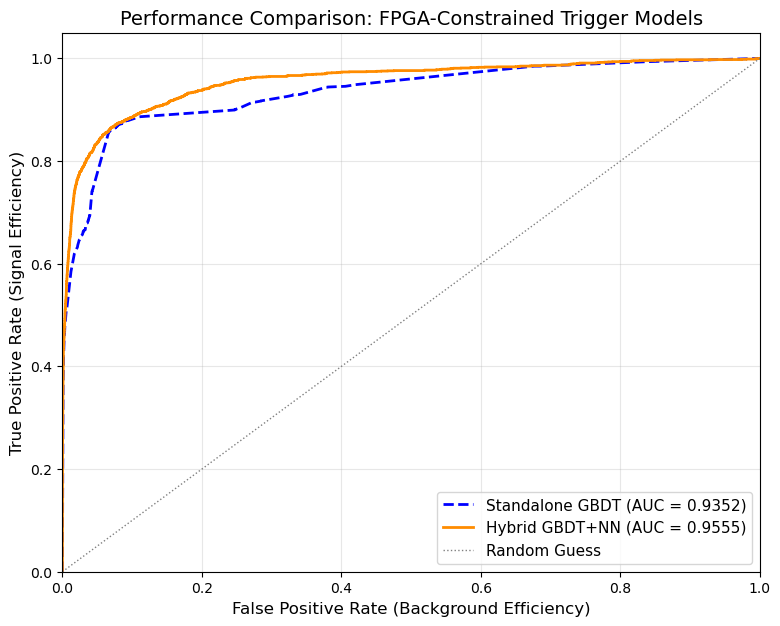


 PERFORMANCE SUMMARY
   Standalone GBDT AUC: 0.9352
   Hybrid System AUC:   0.9555
   Improvement:         +2.03%


In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function to convert GBDT margins to probabilities
import os

# --- PATH CONFIGURATION ---
BASE_DIR = "C:/Users/tanma/FYP"

# ==============================================================================
# 6. COMPARATIVE VISUALIZATION: Standalone GBDT vs. Hybrid
# ==============================================================================
print("\n📊 Generating Comparative ROC Curve...")

# -----------------------------
# 1. GBDT (Standalone)
# -----------------------------
# We use the raw margins we saved earlier (X_test_margin)
# Apply sigmoid to get 0-1 probabilities
y_prob_gbdt = expit(X_test_margin) 

fpr_gbdt, tpr_gbdt, _ = roc_curve(y_test, y_prob_gbdt)
auc_gbdt = auc(fpr_gbdt, tpr_gbdt)

# -----------------------------
# 2. Hybrid (GBDT + NN)
# -----------------------------
# Get NN predictions
y_prob_nn = mlp.predict(X_test_hybrid, verbose=0).ravel()

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)
auc_nn = auc(fpr_nn, tpr_nn)

# -----------------------------
# 3. Plotting
# -----------------------------
plt.figure(figsize=(9, 7))

# Plot GBDT (Baseline)
plt.plot(fpr_gbdt, tpr_gbdt, color='blue', linestyle='--', lw=2, 
         label=f'Standalone GBDT (AUC = {auc_gbdt:.4f})')

# Plot Hybrid (Proposed Solution)
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, 
         label=f'Hybrid GBDT+NN (AUC = {auc_nn:.4f})')

# Plot Random Guess
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', label='Random Guess')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Background Efficiency)', fontsize=12)
plt.ylabel('True Positive Rate (Signal Efficiency)', fontsize=12)
plt.title('Performance Comparison: FPGA-Constrained Trigger Models', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# --- SAVE PLOT TO FYP FOLDER ---
save_path = os.path.join(BASE_DIR, "roc_curve_comparison.png")
plt.savefig(save_path, dpi=300)
print(f"✅ Plot saved to: {save_path}")

# Show plot
plt.show()

# -----------------------------
# 4. Print Summary
# -----------------------------
print(f"\n PERFORMANCE SUMMARY")
print(f"   Standalone GBDT AUC: {auc_gbdt:.4f}")
print(f"   Hybrid System AUC:   {auc_nn:.4f}")
diff = (auc_nn - auc_gbdt) * 100
print(f"   Improvement:         +{diff:.2f}%")

Standard Operating Procedure (SOP)
Phase 2: FPGA Firmware Generation (Linux/WSL)
Objective: To convert trained Machine Learning models (GBDT and Neural Network) into synthesizable C++ firmware for Xilinx Artix-7 FPGA using the Linux environment.

Prerequisites:

Windows Phase 1 completed (Artifacts saved in C:\Users\tanma\FYP\fpga_artifacts).

WSL (Ubuntu) installed with Vivado Design Suite 2024.1 (or compatible).

Step 1: First-Time Environment Setup
(Perform this step ONLY ONCE to create the workspace)

Open Linux Terminal: Launch your WSL terminal (Ubuntu).

Create Dedicated Environment: Create a clean Python 3.10 environment named fyp_env.

Bash

conda create -n fyp_env python=3.10 -y
Activate Environment:

Bash

conda activate fyp_env
Install Dependencies: Install the specific tools required for HLS conversion.

Bash

pip install tensorflow hls4ml conifer scikit-learn pandas numpy xgboost
Step 2: Routine Start-Up
(Perform this step EVERY TIME you open a new terminal window)

Open Linux Terminal.

Activate Environment:

Bash

conda activate fyp_env
Navigate to Project Directory:

Bash

cd /mnt/c/Users/tanma/FYP
Source Vivado Tools: This makes the Xilinx compilers available to the system.

Bash

source /tools/Xilinx/Vivado/2024.1/settings64.sh
(Note: Verify your specific path. It is commonly /tools/Xilinx/... or /opt/Xilinx/...)

Step 3: Input Verification
Ensure the model files generated in Windows are visible in Linux.

Check Artifacts:

Bash

ls -l fpga_artifacts/
Success Criteria: You must see these two files listed:

gbdt_model.json

nn_model.h5

Step 4: GBDT Firmware Generation 
Convert the XGBoost model into C++ firmware. This script explicitly loads the JSON model into XGBoost first to ensure compatibility.

Create Conversion Script: Copy and paste this block into the terminal to create generate_gbdt_hls.py.

Bash

cat <<EOF > generate_gbdt_hls.py
import conifer
import xgboost as xgb
import shutil
import os
import sys

# --- CONFIGURATION ---
BASE_DIR = "."
ARTIFACTS_DIR = os.path.join(BASE_DIR, "fpga_artifacts")
OUTPUT_DIR = os.path.join(BASE_DIR, "fpga_gbdt_project")
MODEL_PATH = os.path.join(ARTIFACTS_DIR, "gbdt_model.json")

print(f"⚡ [GBDT] Starting Conversion for: {MODEL_PATH}")

# 1. Clean previous project
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

# 2. Configure Backend (Xilinx HLS)
backend = conifer.backends.get_backend('xilinxhls')
cfg = backend.auto_config()

# Precision: ap_fixed<18,8> (Safety margin for first run)
cfg['Precision'] = 'ap_fixed<18,8>'
cfg['OutputDir'] = OUTPUT_DIR
cfg['XilinxPart'] = 'xc7a35tcpg236-1' # Artix-7

try:
    # 3. Load Model (Robust Method)
    print("   - Loading JSON into XGBoost...")
    bst = xgb.Booster()
    bst.load_model(MODEL_PATH)

    # 4. Convert
    print("   - Converting to HLS...")
    ensemble_dict = conifer.converters.xgboost.convert(bst)
    model = backend.make_model(ensemble_dict, cfg)

    # 5. Write Files
    model.write()
    print(f"✅ [GBDT] Success! Firmware written to: {OUTPUT_DIR}")

except Exception as e:
    print(f"❌ [GBDT] Error: {e}")
    sys.exit(1)
EOF

Run Script:

Bash

python3 generate_gbdt_hls.py

Run Script:

Bash

python3 generate_gbdt_hls.py

Step 5: Neural Network Firmware Generation (Corrected)
Convert the Neural Network model into C++ firmware with 18-bit precision to match the GBDT output width.

Create Conversion Script: Copy and paste this block to create generate_nn_hls.py.

Bash

cat <<EOF > generate_nn_hls.py
import hls4ml
import tensorflow as tf
import os
import sys

# --- CONFIGURATION ---
BASE_DIR = "."
ARTIFACTS_DIR = os.path.join(BASE_DIR, "fpga_artifacts")
OUTPUT_DIR = os.path.join(BASE_DIR, "fpga_nn_project")
MODEL_PATH = os.path.join(ARTIFACTS_DIR, "nn_model.h5")

print(f"⚡ [NN] Starting Conversion for: {MODEL_PATH}")

# 1. Load Model
try:
    model = tf.keras.models.load_model(MODEL_PATH)
except Exception as e:
    print(f"❌ [NN] Failed to load model: {e}")
    sys.exit(1)

# 2. Configure HLS
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Precision: ap_fixed<18,8> (MUST match GBDT precision)
# 18 total bits, 8 integer bits.
print("   - Setting precision to ap_fixed<18,8>...")
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Precision'] = 'ap_fixed<18,8>'
    config['LayerName'][layer]['ReuseFactor'] = 1

# 3. Convert & Write
try:
    hls_model = hls4ml.converters.convert_from_keras_model(
        model,
        hls_config=config,
        output_dir=OUTPUT_DIR,
        part='xc7a35tcpg236-1'
    )
    hls_model.write()
    print(f"✅ [NN] Success! Firmware written to: {OUTPUT_DIR}")
except Exception as e:
    print(f"❌ [NN] Conversion Error: {e}")
    sys.exit(1)
EOF
Run Script:

Bash

python3 generate_nn_hls.py

Step 6: Firmware Synthesis (Validation)
Verify that the generated C++ code is syntactically correct and package it into an IP core. We use a custom script method here to strictly enforce "Synthesis Only" (bypassing the time-consuming and error-prone simulation steps).

6A. Synthesize GBDT Project

Navigate into the GBDT project folder:

Bash

cd fpga_gbdt_project
Create a clean synthesis script (run_synth.tcl) that forces IP export: Note: Conifer projects usually name the project my_prj.

Bash

cat <<EOF > run_synth.tcl
open_project my_prj
open_solution solution1
csynth_design
export_design -format ip_catalog
exit
EOF
Execute the script:

Bash

vitis_hls -f run_synth.tcl
(Wait for "Finished export_design")

Verify success and return to root:

Bash

ls -R | grep ".zip"
cd ..
6B. Synthesize Neural Network Project

Navigate into the NN project folder:

Bash

cd fpga_nn_project
Create a clean synthesis script (run_synth.tcl): Note: hls4ml projects usually name the project myproject_prj.

Bash

cat <<EOF > run_synth.tcl
open_project myproject_prj
open_solution solution1
csynth_design
export_design -format ip_catalog
exit
EOF
Execute the script:

Bash

vitis_hls -f run_synth.tcl
(Wait for "Finished export_design")

Verify success and return to root:

Bash

ls -R | grep ".zip"
cd ..
End of Phase 2. Result: You now have two validated .zip IP cores (one for GBDT, one for NN) ready for Vivado integration.

Standard Operating Procedure (SOP)
Phase 3: System Integration (Vivado Block Design)
Objective: To integrate the GBDT and Neural Network IP cores into a unified 
"Hybrid Trigger" hardware pipeline on the Xilinx Artix-7 FPGA using Vivado (Linux/WSL).

Prerequisites:

Phase 2 Completed (IP .zip files generated).

Vivado 2024.1 (or compatible) running on Linux/WSL.

Step 1: Project Setup
Launch Vivado: Open terminal and run vivado &.

Create Project:

Name: comet_trigger_integration

Location: /mnt/c/Users/tanma/FYP

Type: RTL Project (Do not specify sources).

Part: xc7a35tcpg236-1 (Artix-7).

Import IP Repository:

Go to Settings > IP > Repository.

Click Add (+) and select /mnt/c/Users/tanma/FYP.

Check: Verify that "2 IPs found" (my_prj and myproject_prj) appears.

Step 2: Add Required Blocks
Create a Block Design named trigger_system and add the following 7 IP blocks to the canvas:

my_prj (Conifer): Named my_prj_0. This is the GBDT Filter (Stage 1).

myproject (hls4ml): Named myproject_0. This is the Neural Network (Stage 2).

Clocking Wizard: Named clk_wiz_0. Manages the system clock.

Processor System Reset: Named proc_sys_reset_0. Manages system reset logic.

Constant (Logic 1): Named xlconstant_1. Set value to 1. Used for "Always On" signals.

Constant (Logic 0): Named xlconstant_0. Set value to 0. Used for tying off unused pins.

Concat (Bundler): Named raw_bundler. Set Number of Ports to 10.

Concat (Combiner): Named hybrid_combiner. Set Number of Ports to 2.

Step 3: The Connection Map (Wiring Guide)
Follow these connections exactly to ensure a valid pipeline.

A. The Data Pipeline (Hybrid Architecture)
Create External Inputs:

Go to raw_bundler. Right-click pins In0 through In9 and select Make External.

Result: You now have 10 Input Ports named In0_0...In9_0.

Feed the GBDT:

Connect each External Input Port (In0_0...In9_0) to the corresponding Input Pin on the GBDT block (my_prj_0).

Note: The wires will split: one branch goes to the Bundler, one branch goes to the GBDT.

Feed the Combiner (Hybrid Link):

Connect raw_bundler Output (dout) to hybrid_combiner Input (In0).

Connect GBDT Output (score_0) to hybrid_combiner Input (In1).

Feed the Neural Network:

Connect hybrid_combiner Output (dout) to Neural Network Input (input_layer_5).

Final Output:

Right-click Neural Network Output (layerX_out) and select Make External.

Rename this port to trigger_decision.

B. The Control Network (Start and Valid)
Enable GBDT:

Connect xlconstant_1 (Value 1) to my_prj_0/ap_start.

Enable Neural Network:

Connect xlconstant_1 (Value 1) to myproject_0/ap_start.

Force Data Validity:

Connect xlconstant_1 (Value 1) to myproject_0/input_layer_5_ap_vld.

Critical: Without this, the NN ignores all input data.

C. The Clean-Up (Tying off Unused Pins)
Tie off GBDT Offset:

Connect xlconstant_0 (Value 0) to my_prj_0/score_1.

D. The Clock and Reset Network
Clock Distribution:

Connect clk_wiz_0/clk_out1 to proc_sys_reset_0/slowest_sync_clk.

Connect clk_wiz_0/clk_out1 to my_prj_0/ap_clk.

Connect clk_wiz_0/clk_out1 to myproject_0/ap_clk.

Reset Distribution:

Connect proc_sys_reset_0/peripheral_reset (Active High) to my_prj_0/ap_rst.

Connect proc_sys_reset_0/peripheral_reset (Active High) to myproject_0/ap_rst.

System Synchronization:

Connect clk_wiz_0/locked to proc_sys_reset_0/dcm_locked.

External Connections:

Right-click clk_wiz_0/clk_in1 and select Make External (Name it: sys_clock).

Right-click proc_sys_reset_0/ext_reset_in and select Make External (Name it: sys_reset).

Connect clk_wiz_0/reset to the sys_reset port as well.

Step 4: Final Validation and Build
Validate: Press F6.

Success Criteria: "Validation Successful" message. No Critical Warnings about ap_rst, ap_vld, or In1.

Create Wrapper:

Go to Sources Tab.

Right-click trigger_system and select Create HDL Wrapper.

Select "Let Vivado manage wrapper" and click OK.

Generate Bitstream:

Click Generate Bitstream in the Flow Navigator.

Confirm Yes to run Synthesis and Implementation.

Duration: 15-30 Minutes.

End of Phase 3.

In [ ]:
GitHub Update Workflow
Every time you edit your Jupyter Notebook (fypv3.ipynb), you must follow this three-step process in your WSL terminal:

1. Stage the Change (git add)
This tells Git, "I want to include this edited file in the next save point."

Action: In your terminal (ensuring you are in the /mnt/c/Users/tanma/FYP directory), run:

Bash

git add fypv3.ipynb
If you edit any of the model files, you should also stage the folder:

Bash

git add fpga_artifacts
2. Commit the Change (git commit)
This creates a permanent "snapshot" of the change in your local repository's history.

Action: Provide a clear message describing what you changed (e.g., increased training epochs, fixed a bug, updated visualization).

Bash

git commit -m "Updated Phase 1: Increased MLP epochs for better accuracy."
3. Push to GitHub (git push)
This sends the local snapshot (the commit) from your machine to the remote repository on GitHub, making the changes visible to the world.

Action: Since you set up the connection previously, you can usually just run:

Bash

git push
(Note: If Git asks for your password, you must use the Personal Access Token (PAT) you generated earlier).